# Time Series Modelling and Granger Causality Analysis for Marriage and Fertility

This notebook explores the relationship between the percentage of women aged 15-49 who are married or in union ("Marriage %") and the fertility rate across European countries using time series analysis. First I'll apply ARIMA models to forecast trends for both variables and use Granger causality tests to investigate potential predictive relationships between them. I aim to provide insights into how changes in marriage patterns may relate to fertility trends, and vice versa. Model performance is compared using both univariate and multivariate approaches.

## Libraries and data import

In [1]:
import sys
import os
import warnings
import traceback

sys.path.append(os.path.abspath(".."))
os.makedirs("../data", exist_ok=True)

# data manipulation
import pandas as pd

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
from src.modelling import load_and_prepare_data, arima_forecast, granger_test, run_models_for_continent, highlight_improvements
from src.viz import highlight_improvements

In [2]:
df = load_and_prepare_data('../data/cleaned_combined_data.csv')
df = df.rename(columns={col: col.replace('Estimate', 'Marriage') for col in df.columns if 'Estimate' in col})
df.head()

,Entity,Code,Year,Marriage,Country,Continent,Fertility Rate
0,Afghanistan,AFG,1970,80.93764,Afghanistan,Asia,7.400
1,Afghanistan,AFG,1971,80.90172,Afghanistan,Asia,7.432
2,Afghanistan,AFG,1972,80.87052,Afghanistan,Asia,7.453
3,Afghanistan,AFG,1973,80.84053,Afghanistan,Asia,7.487
4,Afghanistan,AFG,1974,80.53404,Afghanistan,Asia,7.526


## ARIMA Forecasts for European Countries
Now I'll visualise percentage change forecasts for both `Marriage` and `Fertility Rate` using ARIMA models.

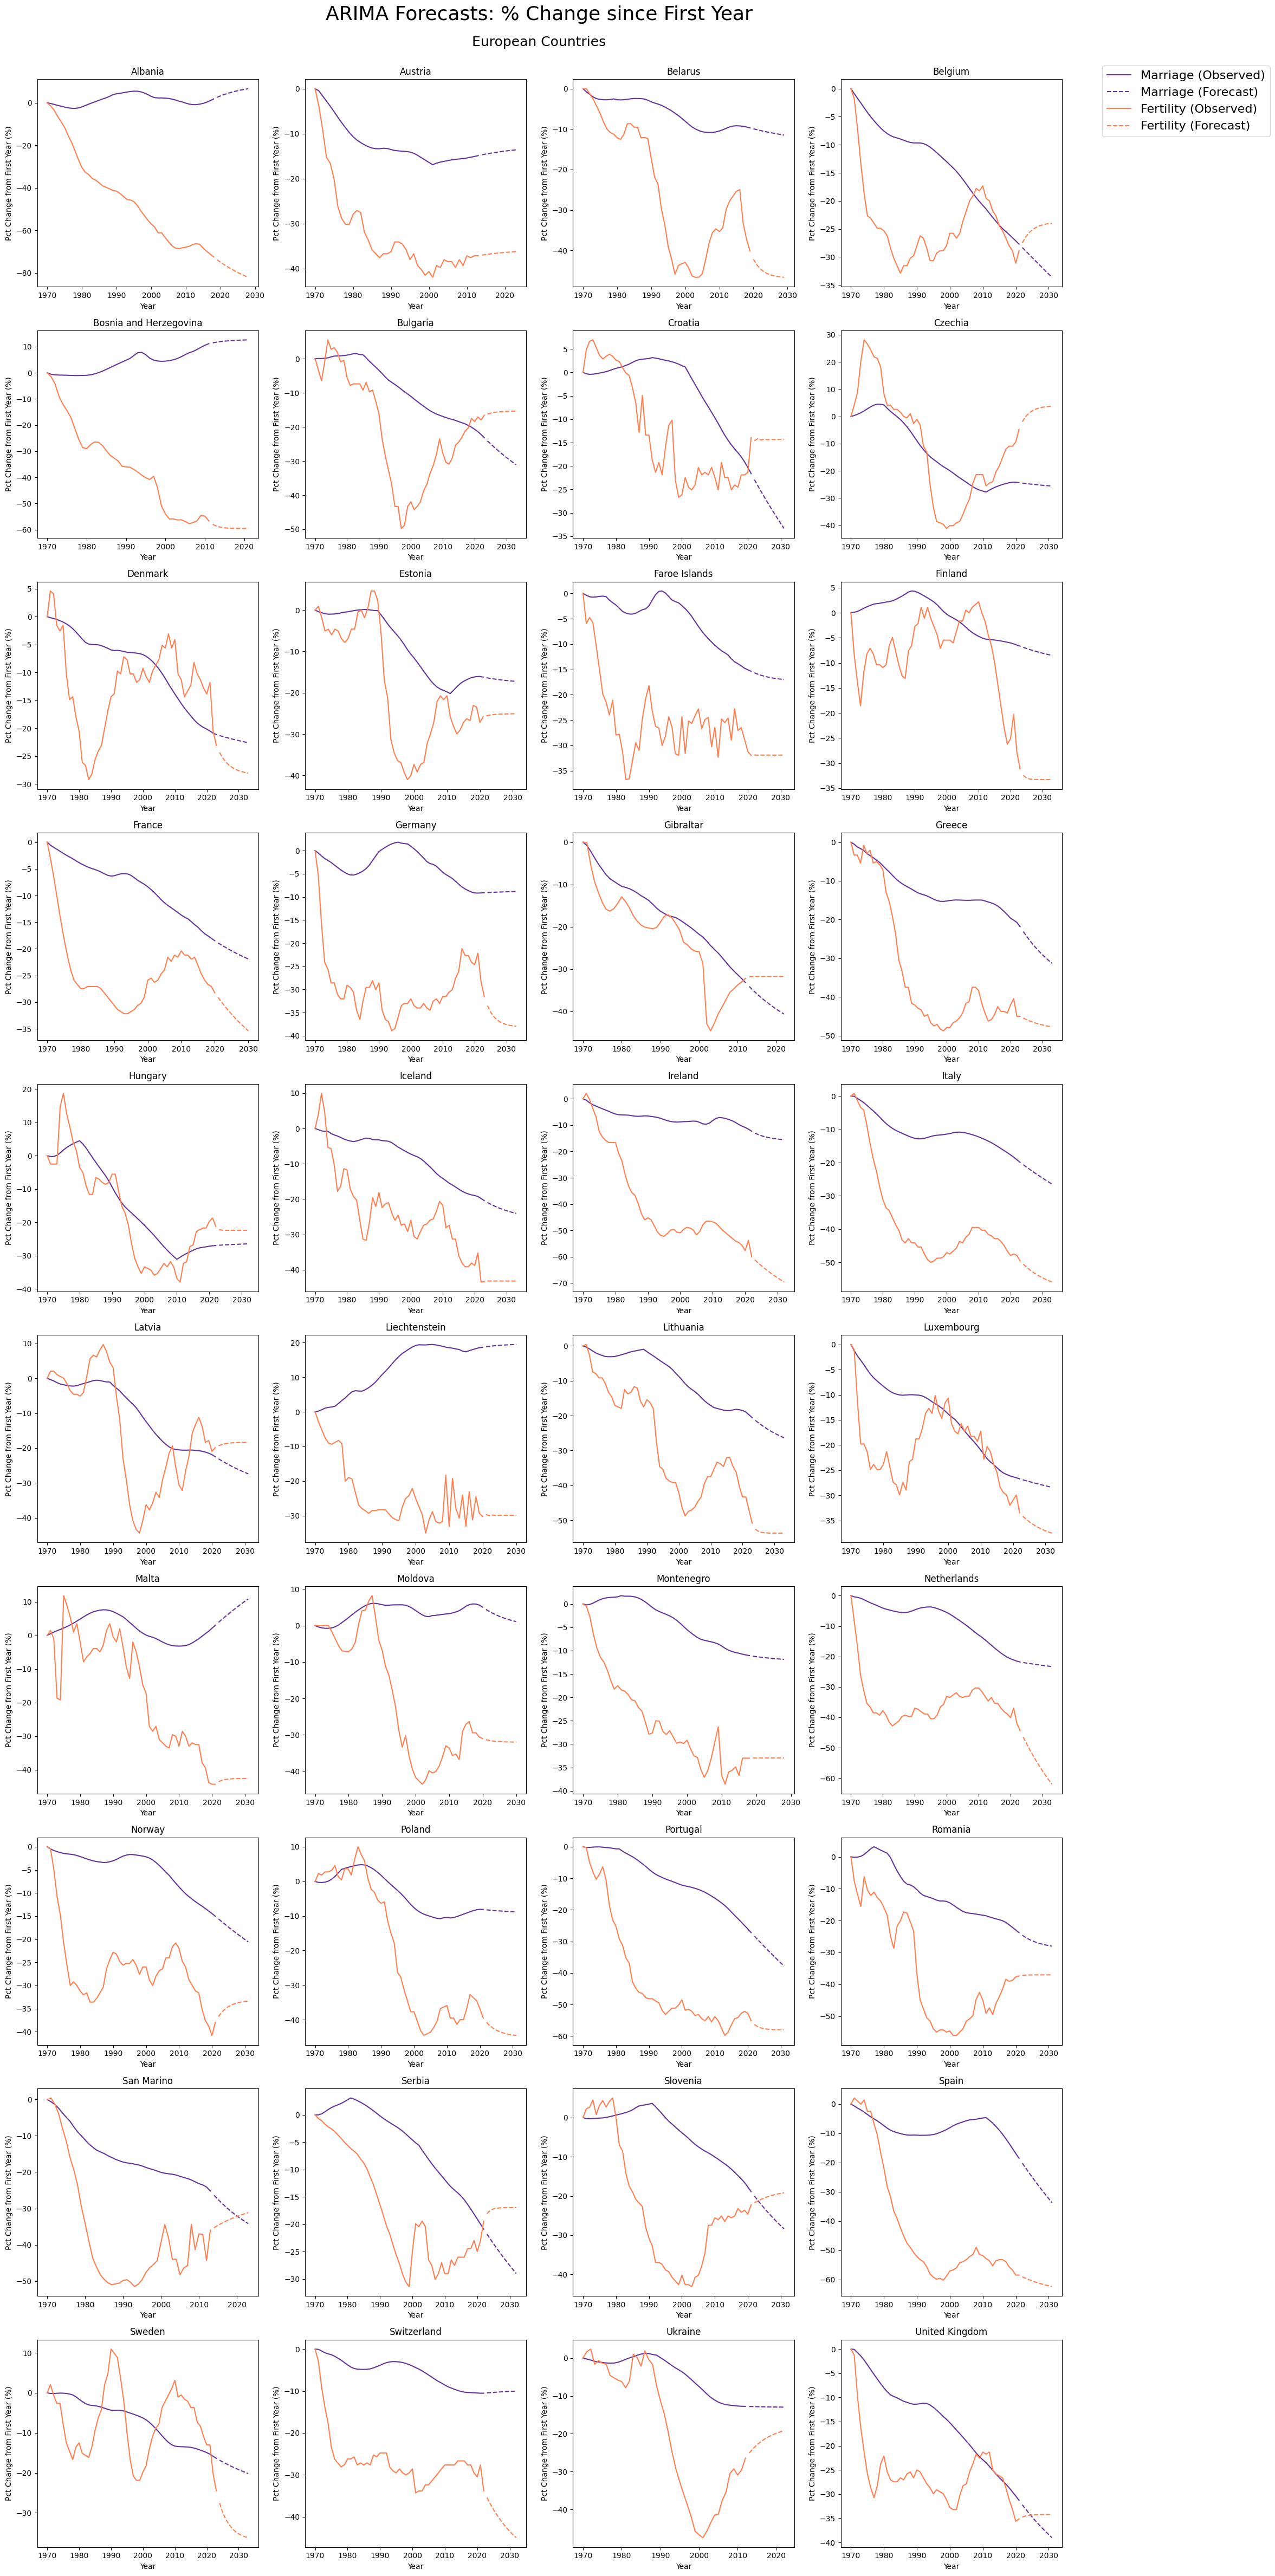

In [ ]:
warnings.filterwarnings("ignore")

europe_df = df[df['Continent'] == 'Europe'].copy()
europe_df = europe_df.dropna(subset=['Marriage', 'Fertility Rate', 'Year'])

countries = europe_df['Country'].unique()
n_cols = 4
n_rows = (len(countries) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

forecast_steps = 10
legend_added = False
color_estimate = 'rebeccapurple'
color_fertility = 'coral'

for i, country in enumerate(countries):
    ax = axes[i]
    country_df = europe_df[europe_df['Country'] == country].sort_values('Year').set_index('Year')

    try:
        est_pct, est_forecast, est_years = arima_forecast(country_df, 'Marriage', forecast_steps)
        fert_pct, fert_forecast, fert_years = arima_forecast(country_df, 'Fertility Rate', forecast_steps)

        line1, = ax.plot(est_pct, label='Marriage (Observed)', color=color_estimate)
        line2, = ax.plot(est_years, est_forecast, '--', label='Marriage (Forecast)', color=color_estimate)

        line3, = ax.plot(fert_pct, label='Fertility (Observed)', color=color_fertility)
        line4, = ax.plot(fert_years, fert_forecast, '--', label='Fertility (Forecast)', color=color_fertility)

        ax.set_title(country)
        ax.set_xlabel('Year')
        ax.set_ylabel('Pct Change from First Year (%)')

        if not legend_added:
            legend_handles = [line1, line2, line3, line4]
            legend_labels = [line.get_label() for line in legend_handles]
            legend_added = True

    except Exception as e:
        ax.set_title(f"{country} (Error)")
        ax.text(0.5, 0.5, str(e), ha='center', va='center')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1.18, 0.96), fontsize=16)
plt.suptitle("ARIMA Forecasts: % Change since First Year", fontsize=26)
fig.text(0.5, 0.965, "European Countries", fontsize=18, ha='center')
plt.tight_layout(rect=[0, 0.03, 0.99, 0.97])
plt.show()

## Granger Causality: Fertility Rate ➜ Marriage %
Here, I test whether changes in fertility can predict changes in marriage percentages.

In [4]:
results = []

for country in europe_df['Country'].unique():
    df_country = europe_df[europe_df['Country'] == country].sort_values('Year')
    if df_country.shape[0] < 10:
        continue
    try:
        res = granger_test(df_country[['Marriage', 'Fertility Rate']], cause='Fertility Rate', effect='Marriage', max_lag=2)
        for _, row in res.iterrows():
            results.append({'Country': country, 'Lag': row['Lag'], 'P-Value': row['P-Value'], 'Significant (p<0.05)': row['Significant (p<0.05)']})
    except:
        continue

results_df = pd.DataFrame(results)
summary_df = results_df.loc[results_df.groupby('Country')['P-Value'].idxmin()].sort_values('P-Value')
summary_df


,Country,Lag,P-Value,Significant (p<0.05)
76,Ukraine,1,5.301638e-10,True
6,Belgium,1,1.052453e-09,True
40,Latvia,1,3.957232e-09,True
12,Croatia,1,6.492090e-09,True
38,Italy,1,1.120883e-08,True
58,Poland,1,2.183887e-08,True
68,Slovenia,1,2.678259e-08,True
4,Belarus,1,1.559791e-07,True
18,Estonia,1,4.590109e-07,True
44,Lithuania,1,8.488115e-07,True


## Reverse Granger Causality: Marriage % (Estimate) ➜ Fertility Rate
Next, check the reverse direction.

In [5]:

reverse_results = []

for country in europe_df['Country'].unique():
    df_country = europe_df[europe_df['Country'] == country].sort_values('Year')
    if df_country.shape[0] < 10:
        continue
    try:
        res = granger_test(df_country[['Marriage', 'Fertility Rate']], cause='Marriage', effect='Fertility Rate', max_lag=2)
        for _, row in res.iterrows():
            reverse_results.append({'Country': country, 'Lag': row['Lag'], 'P-Value': row['P-Value'], 'Significant (p<0.05)': row['Significant (p<0.05)']})
    except:
        continue

reverse_results_df = pd.DataFrame(reverse_results)
reverse_summary_df = reverse_results_df.loc[reverse_results_df.groupby('Country')['P-Value'].idxmin()].sort_values('P-Value')
reverse_summary_df


,Country,Lag,P-Value,Significant (p<0.05)
70,Spain,1,0.000098,True
76,Ukraine,1,0.000731,True
68,Slovenia,1,0.003197,True
41,Latvia,2,0.006041,True
27,Germany,2,0.013577,True
22,Finland,1,0.014217,True
51,Moldova,2,0.022566,True
47,Luxembourg,2,0.023178,True
59,Poland,2,0.023375,True
7,Belgium,2,0.024094,True


In [6]:
# Count of countries where causality is significant
fert_to_est = summary_df[summary_df['Significant (p<0.05)']].shape[0]
est_to_fert = reverse_summary_df[reverse_summary_df['Significant (p<0.05)']].shape[0]

print(f"Number of countries where Fertility ➜ Estimate is significant: {fert_to_est}")
print(f"Number of countries where Estimate ➜ Fertility is significant: {est_to_fert}")


Number of countries where Fertility ➜ Estimate is significant: 32
Number of countries where Estimate ➜ Fertility is significant: 14


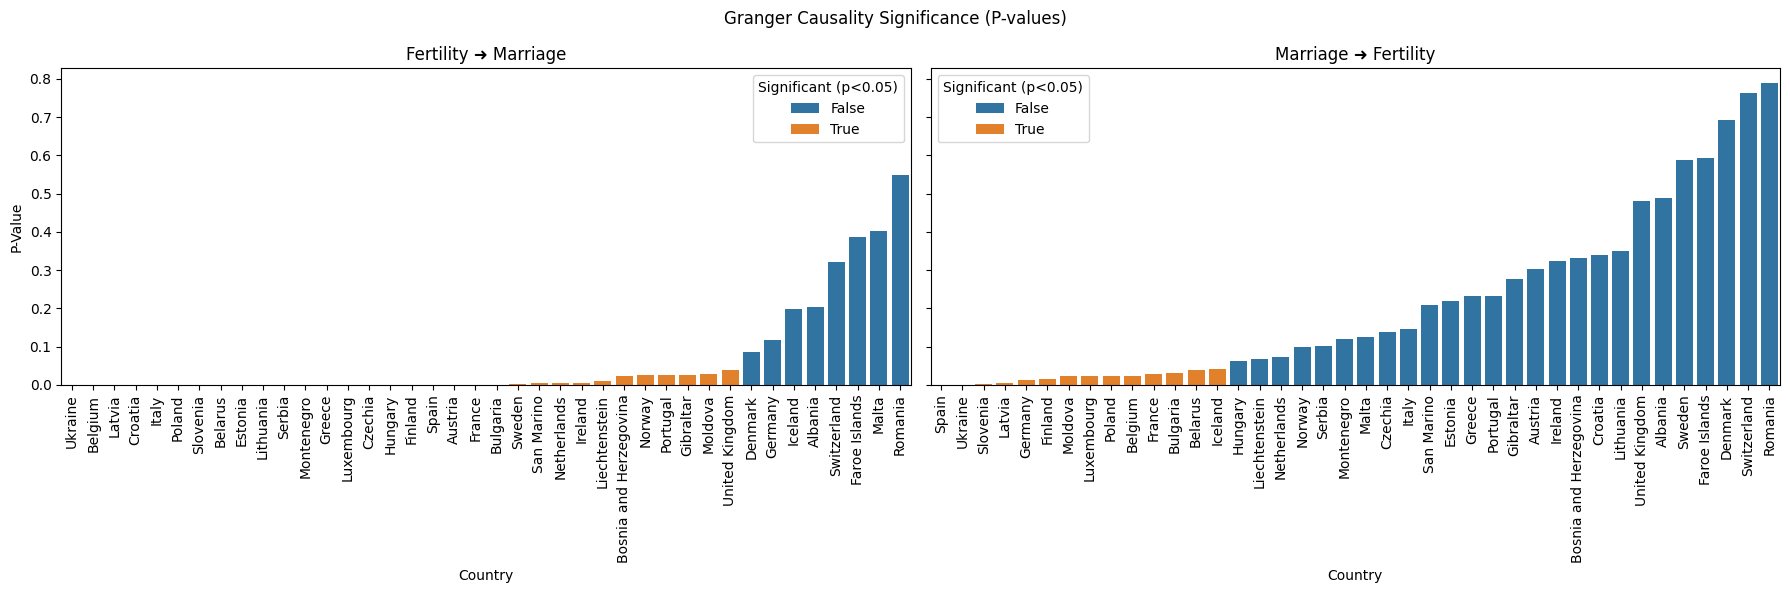

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Fertility ➜ Marriage
sns.barplot(data=summary_df, x='Country', y='P-Value', hue='Significant (p<0.05)', ax=axes[0])
axes[0].set_title('Fertility ➜ Marriage')
axes[0].tick_params(axis='x', rotation=90)

# Marriage ➜ Fertility
reverse_summary_df = pd.DataFrame(reverse_results)
if not reverse_summary_df.empty:
    reverse_summary = reverse_summary_df.loc[reverse_summary_df.groupby('Country')['P-Value'].idxmin()].sort_values('P-Value')
    sns.barplot(data=reverse_summary, x='Country', y='P-Value', hue='Significant (p<0.05)', ax=axes[1])
    axes[1].set_title('Marriage ➜ Fertility')
    axes[1].tick_params(axis='x', rotation=90)

plt.suptitle('Granger Causality Significance (P-values)')
plt.tight_layout()
plt.show()


## Multivariate Forecasting with Vector Autoregression (VAR)

In this section, I'll use Vector Autoregression (VAR) models to forecast marriage prevalence and fertility rates for European countries. Unlike univariate models, VAR is a multivariate time series approach that captures the dynamic interdependencies between multiple variables—in this case, the percentage of women aged 15-49 who are married or in union ("Marriage %") and the fertility rate. 

By modeling both series together, VAR can account for feedback effects and shared temporal patterns, potentially improving forecast accuracy for each variable.

In [8]:
# Rename the relevant columns
df = df.rename(columns={'Marriage': 'Marriage', 'Fertility Rate': 'Fertility'})

# run the modeling pipeline for Europe
results_df = run_models_for_continent(df, continent='Europe', lags=2, train_ratio=0.8)
styled = highlight_improvements(results_df)
display(styled)

,Country,Marriage MSE (Univariate),Marriage MSE (With Fertility),Marriage MSE Reduction (%),Fertility MSE (Univariate),Fertility MSE (With Marriage),Fertility MSE Reduction (%)
0,United Kingdom,4.00,0.39,90.2%,0.01,0.03,-151.6%
1,Albania,0.49,0.05,89.5%,0.03,0.15,-384.7%
2,Bosnia and Herzegovina,4.67,0.74,84.2%,0.00,0.01,-211.6%
3,Ireland,4.51,0.76,83.1%,0.04,0.04,12.3%
4,Norway,1.35,0.37,72.4%,0.04,0.33,-747.5%
5,Latvia,12.90,4.67,63.8%,0.10,0.07,32.2%
6,Hungary,37.76,14.62,61.3%,0.08,0.02,77.0%
7,Sweden,8.75,4.40,49.7%,0.01,0.08,-447.1%
8,Luxembourg,10.12,5.66,44.1%,0.02,0.02,20.4%
9,San Marino,1.76,1.01,42.3%,0.02,0.03,-17.9%


## VAR Top Performers: Strong Predictive Link
### 🇬🇧 United Kingdom
#### Marriage MSE ↓ 90.2%, but Fertility MSE ↑ –151.6%
- Interpretation: Fertility trends are highly predictive of marriage trends, but not the other way around.
Context:
- The UK shows delayed childbearing and high cohabitation rates. Fertility decisions may precede or shape marriage decisions, especially in contexts with supportive family planning policies.

### 🇦🇱 Albania, 🇧🇦 Bosnia and Herzegovina
#### Marriage MSE reduced by ~85–90%, but Fertility MSE worsened
- Interpretation: Fertility decline (due to urbanization, emigration) likely drives marriage trends (delayed, fewer formal unions).
Context: 
- Traditional societies transitioning to modern norms, where childbirth becomes less tied to formal union.

### 🇮🇸 Iceland, 🇭🇺 Hungary, 🇱🇻 Latvia
#### Strong reductions in both Marriage and Fertility MSEs

- Interpretation: Mutual reinforcement — decisions around marriage and fertility are closely coupled.
Context: 
- Iceland, Hungary: Strong family policy frameworks (e.g., childcare subsidies, paid parental leave) encourage coordinated family formation.
- Latvia: Post-Soviet shifts led to synchronized demographic changes in both marriage and fertility.

## VAR Negative Performers: Including both variables worsened prediction
### 🇺🇦 Ukraine, 🇫🇷 France, 🇬🇮 Gibraltar
#### Marriage MSE increased by 1000%+
- Interpretation: Fertility adds noise, not signal, to marriage prediction.
Context:
- Ukraine: War, instability, and migration have decoupled social behaviors like marriage and childbirth.
- France: Maintains high fertility with low marriage rates (strong cohabitation, state support).
- Gibraltar: Small population + unique external influences (e.g., UK proximity, religion) skew trends.

### 🇵🇱 Poland, 🇸🇮 Slovenia, 🇩🇰 Denmark
#### Fertility MSE exploded when including marriage
- Interpretation: Fertility decisions often happen outside of marriage.
Context:
- Denmark, Slovenia: Liberal family structures support non-marital fertility.
- Poland: Religious norms persist, but actual behavior (especially among youth) diverges from traditional marriage-based reproduction.

## Mixed Countries: Some benefit, some noise
### 🇩🇪 Germany
#### Minimal MSE reduction
- Possibly because both marriage and fertility are more influenced by external factors (e.g., policy, economy, migration) than by each other.
### 🇱🇺 Luxembourg, 🇫🇮 Finland
#### Moderate gains
Context: 
- Wealthy, small populations with strong welfare states — some predictability, but external influences (e.g., immigration) likely play a significant role.